In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, inspect, func

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
inspector = inspect(engine)
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [9]:
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [12]:
#calculate max date with max function (func.max)
max_date=session.query(func.max(Measurement.date)).all()[0][0]
Measurement

sqlalchemy.ext.automap.measurement

# Exploratory Climate Analysis

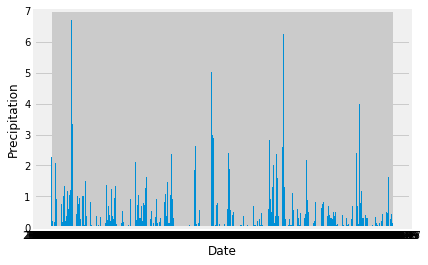

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
#prev_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)
# Calculate the date 1 year ago from the last data point in the database
prev_year = dt.datetime.strptime(max_date,"%Y-%m-%d") - dt.timedelta(days=365)
# Perform a query to retrieve the data and precipitation scores
sel = [Measurement.date,Measurement.prcp]
year_data=session.query(*sel).\
 filter(Measurement.date >= prev_year).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df=pd.DataFrame(year_data)
# Use Pandas Plotting with Matplotlib to plot the data
plt.bar(prcp_df['date'],prcp_df['prcp'])
plt.ylabel('Precipitation')
plt.xlabel('Date')
plt.show()

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [15]:
# Design a query to show how many stations are available in this dataset?
no_stations=session.query(func.count(Station.id)).all()[0][0]
no_stations

9

In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations=session.query(Measurement.station,func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
most_active=active_stations[0][0]
most_active_stats=session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
filter(Measurement.station==most_active).all()
most_active_stats

[(54.0, 85.0, 71.66378066378067)]

(array([ 5.,  7.,  7., 12., 27., 41., 40., 57., 66., 52., 29.,  8.]),
 array([59., 61., 63., 65., 67., 69., 71., 73., 75., 77., 79., 81., 83.]),
 <a list of 12 Patch objects>)

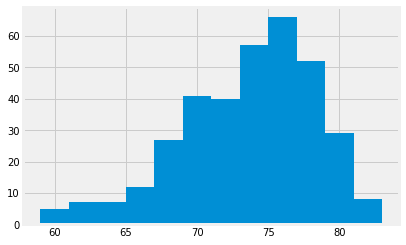

In [18]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
#np.ravel flatten the query data
most_active_data=session.query(Measurement.tobs).\
filter(Measurement.station==most_active).\
filter(Measurement.date >= prev_year).all()
df=pd.DataFrame(most_active_data)
plt.hist(np.ravel(most_active_data),bins=12)